In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
import sys
import math
sys.path.append('..')

from copy import deepcopy
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch import nn

import sys
sys.path.append('../')
from models import ema, anet
from evolutions import *
from utils import stack_imgs
from evaluation import *
import PIL

import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(sns.color_palette("coolwarm", 50))

## MNIST

In [3]:
from utils import get_dataset_MNIST as get_dataset
from config_mnist import get_configs
config = get_configs()
config.data.norm_mean = (0.5)
config.data.norm_std = (0.5)
config.model.task = 'heat'
config.model.evolution = 'dimple'
C = config.data.num_channels

device = torch.device('cuda')
train_loader, val_loader = get_dataset(config)
q_t, sigma, w, dwdt = get_q(config)

In [4]:
x,y = next(iter(train_loader))
x, y = x[:64], y[:64]
x = x.view(64, -1)
y = torch.nn.functional.one_hot(y, num_classes=config.data.ydim).float()
x = torch.hstack([x, y])

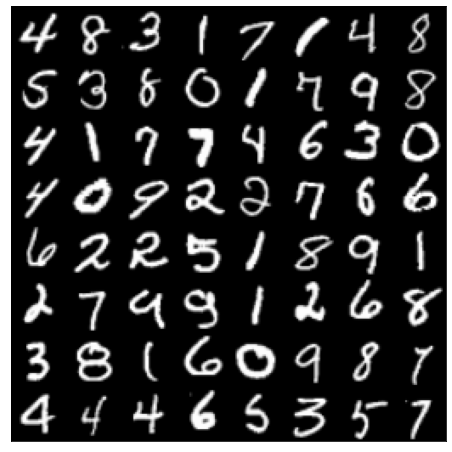

In [5]:
figsize(10,8)
big_img = stack_imgs(x[:,:-config.data.ydim].reshape([-1,C,32,32])*0.5+0.5)
plt.xticks([])
plt.yticks([])
_ = plt.imshow(big_img, cmap='gray')

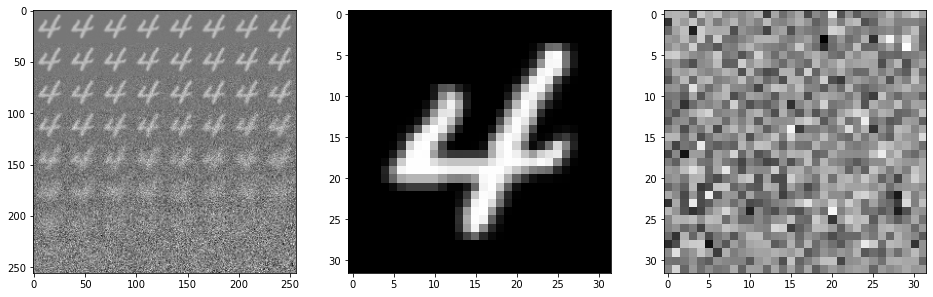

In [6]:
figsize(16,8)

batch = x[:1].repeat([64,1])
x_t = q_t(batch, torch.linspace(0,1,64))

img = np.zeros([8*32,8*32])
k = 0
for k in range(64):
    i, j = k//8, k % 8
    img[i*32:(i+1)*32,j*32:(j+1)*32] = x_t[k].reshape([32,32])*0.5+0.5
plt.subplot(131)
plt.imshow(img, cmap='gray')
plt.subplot(132)
plt.imshow(img[0:32,0:32], cmap='gray')
plt.subplot(133)
plt.imshow(img[i*32:(i+1)*32,j*32:(j+1)*32], cmap='gray')

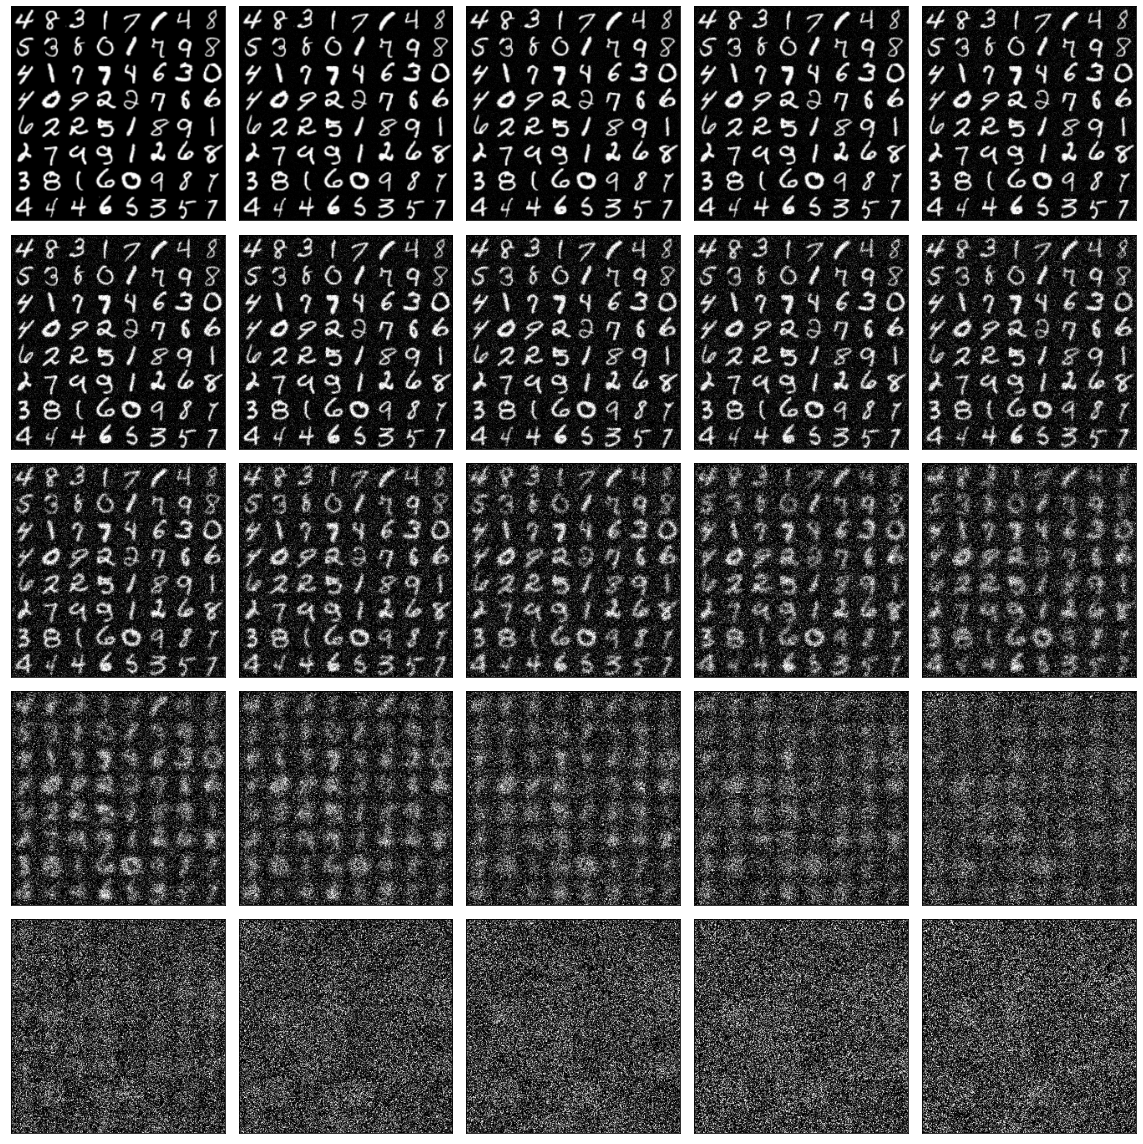

In [7]:
figsize(16,16)

batch = x[:1].repeat([64,1,1,1])
batch = batch.view(64, -1)
y = torch.zeros([64,config.data.ydim])
batch = torch.hstack([batch, y])
x_t = q_t(x, torch.linspace(0,1,64))

t = np.linspace(0,1,25)
for i in range(5):
    for j in range(5):
        plt.subplot(5,5,5*i+j+1)
        img = q_t(x, torch.ones(64)*t[5*i+j])
        img = img.reshape([-1,C,32,32])*0.5+0.5
        plt.xticks([])
        plt.yticks([])
        plt.imshow(stack_imgs(img), cmap='gray')
plt.tight_layout()

## CIFAR

In [13]:
from utils import get_dataset_CIFAR10 as get_dataset
from config_cifar10_32 import get_configs
config = get_configs()
config.data.norm_mean = (0.5, 0.5, 0.5)
config.data.norm_std = (0.5, 0.5, 0.5)
config.model.task = 'superres'
config.model.evolution = 'simple'
C = config.data.num_channels

device = torch.device('cuda')
train_loader, val_loader = get_dataset(config)
q_t, sigma, w, dwdt = get_q(config)

Files already downloaded and verified
Files already downloaded and verified


In [14]:
x,y = next(iter(train_loader))
x, y = x[:64], y[:64]
x = x.view(64, -1)
y = torch.nn.functional.one_hot(y, num_classes=config.data.ydim).float()
x = torch.hstack([x, y])

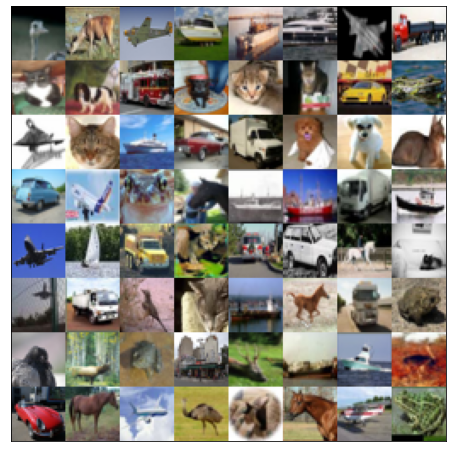

In [15]:
figsize(10,8)
big_img = stack_imgs(x[:,:-config.data.ydim].reshape([-1,C,32,32])*0.5+0.5)
plt.xticks([])
plt.yticks([])
_ = plt.imshow(big_img, cmap='gray')

/h/kirill/condaenvs/pytorch-env/lib/python3.9/site-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


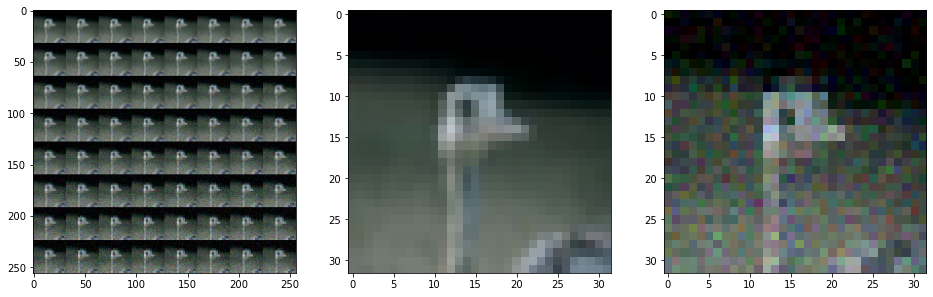

In [16]:
figsize(16,8)

batch = x[:1].repeat([64,1])
x_t = q_t(batch, torch.linspace(0,1,64))

img = np.zeros([8*32,8*32,3])
k = 0
for k in range(64):
    i, j = k//8, k % 8
    img[i*32:(i+1)*32,j*32:(j+1)*32,:] = x_t[k].numpy().reshape([3,32,32]).transpose([1,2,0])*0.5+0.5
plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(img[0:32,0:32,:])
plt.subplot(133)
plt.imshow(img[i*32:(i+1)*32,j*32:(j+1)*32,:])

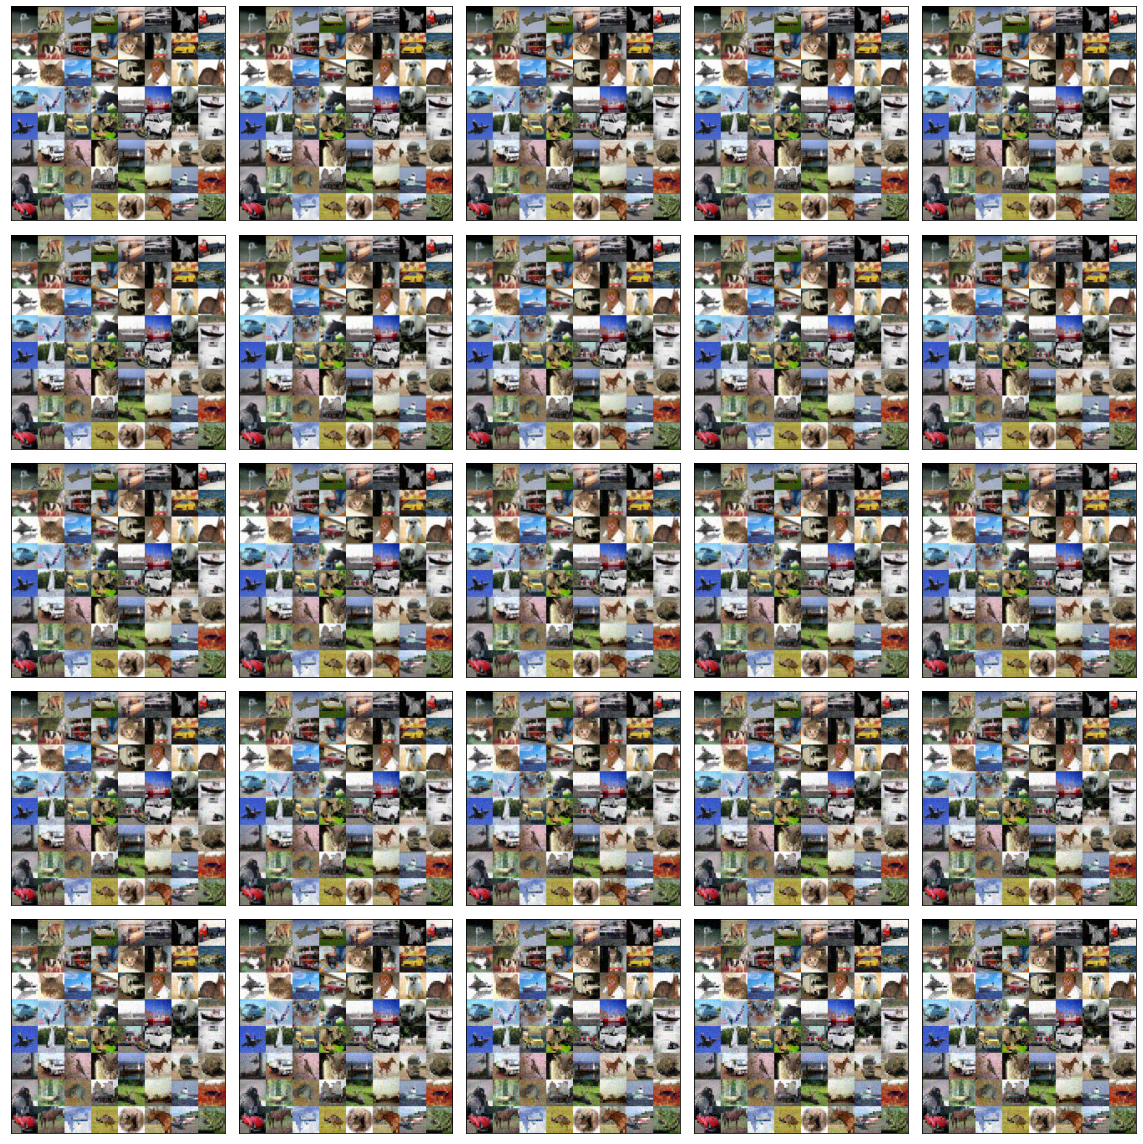

In [17]:
figsize(16,16)

batch = x[:1].repeat([64,1,1,1])
batch = batch.view(64, -1)
y = torch.zeros([64,config.data.ydim])
batch = torch.hstack([batch, y])
x_t = q_t(x, torch.linspace(0,1,64))

t = np.linspace(0,1,25)
for i in range(5):
    for j in range(5):
        plt.subplot(5,5,5*i+j+1)
        img = q_t(x, torch.ones(64)*t[5*i+j])
        img = img.reshape([-1,C,32,32])*0.5+0.5
        plt.xticks([])
        plt.yticks([])
        plt.imshow(stack_imgs(img))
plt.tight_layout()